# Reading file

In [1]:
import pandas as pd

file_name = "Models.csv"
df = pd.read_csv(file_name)

## Getting scores

In [2]:
def get_scores(df, field="minimum"):
    if field != "minimum" and field != "maximum" and field != "average" and field != "weird_metric":
        return None
    id_values = []
    scores_values = []
    episodes_values = []
    for i in range(100, 1600, 100):
        sv = []
        ev = []
        iv = []
        id=0
        for ii in df['scores_' + str(i) + "_" + field]:
            sv.append(ii)
            ev.append(i)
            iv.append("id_" + str(id))
            id+= 1
        scores_values.append(sv)
        episodes_values.append(ev)
        id_values.append(iv)
    return (id_values, scores_values, episodes_values)


id_values, scores_values, episodes_values = get_scores(df, field="average")

## Getting x y data of scores

In [3]:
minl = []
avgl = []
maxl = []
vall = []

def gety_x_y_from_scores(df, field="minimum"):
    if field != "minimum" and field != "maximum" and field != "average" and field != "weird_metric":
        return None
    minl = []
    vall = []
    for i in range(100, 1600, 100):
        minl.append('scores_' + str(i) + "_" + field)
        vall.append(i)
    
    x = []
    y = []
    for i in df[minl].iloc():
        y.append(i.to_list())
        x.append(vall)
    return x, y

x, y = gety_x_y_from_scores(df)
# df[minl]

## DataViz

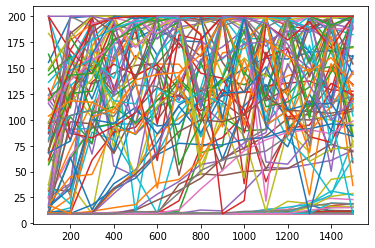

In [4]:
import seaborn as sn

for xx, yy in zip(x, y):
    sn.lineplot(x=xx, y=yy)


# Feature Creation

How to measure chaos and instability during the learning process ?

As so to predict which parameters reduces them in Reinforcement Learning

1. Clustering from similarity measures offers pretty homogenous groups, but does not help for chaos/instability
    1. PCM
    2. Discrete Frechet distance ++
    3. area between two curves
    4. Curve Length based similarity measure
    5. Dynamic Time Warping distance ++
2. Creation of a viariable to measure how much the model regressed:
    1. negative_progress: Sum of all negative differences between x(i - step) - x(i)
    2. last_combo: Start of the last row of values beyond treshold
    3. best_combo: Longest row of values beyond treshold
3. Prediction of correlated Parameters with each param:
    1. Variables:
        1. Best score
        2. negative_progress
        3. last_combo    
        4. best_combo
    2. ALgorithms
        1. Random Forest
        2. Linear regression
        3. Logistic regression

## Similarity measure

In [5]:
import sys  
!{sys.executable} -m pip install --user similaritymeasures

In [27]:
import numpy as np
import similaritymeasures

def curve_similiraty(exp_data, num_data, nb=1):
    everything = False
    pcm = 1
    df = 1
    area = 1
    cl =1
    dtw = 1
    
    if nb == 0 or everything:
        # quantify the difference between the two curves using PCM
        pcm = similaritymeasures.pcm(exp_data, num_data)

    if nb == 1 or everything:
        # quantify the difference between the two curves using
        # Discrete Frechet distance
        df = similaritymeasures.frechet_dist(exp_data, num_data)

    if nb == 2 or everything:
        # quantify the difference between the two curves using
        # area between two curves
        area = similaritymeasures.area_between_two_curves(exp_data, num_data)

    if nb == 3 or everything:
        # quantify the difference between the two curves using
        # Curve Length based similarity measure
        cl = similaritymeasures.curve_length_measure(exp_data, num_data)

    if nb == 4 or everything:
        # quantify the difference between the two curves using
        # Dynamic Time Warping distance
        dtw, d = similaritymeasures.dtw(exp_data, num_data)
    
    ret = [pcm, df, area, cl, dtw]

    return ret[nb]


In [7]:
def compare_id(x, y, a, b, sim_measure=1):
    # Generate random experimental data
    exp_data = np.zeros((15, 2))
    exp_data[:, 0] = x[a]
    exp_data[:, 1] = y[a]

    # Generate random numerical data
    num_data = np.zeros((15, 2))
    num_data[:, 0] = x[b]
    num_data[:, 1] = y[b]

    return curve_similiraty(exp_data, num_data, nb=sim_measure)

test = False

if test:
    compare_id(x, y, 24, 25)
    compare_id(x, y, 24, 22)
    compare_id(x, y, 25, 22)

In [8]:
import sys  
!{sys.executable} -m pip install --user tqdm

In [20]:
from tqdm import tqdm

def get_cov_mat_sim(x, y, sim=1):
    size = len(x)

    cov_mat = []

    with tqdm(range(size), desc="Cov Mat <3 ", unit="line") as tep:
        for i in tep:
            lin_mat = []
            for ii in range(size):
                ret = compare_id(x, y, i, ii, sim)
                if ret == 0:
                    ret += 1e-25
                lin_mat.append(ret)
            cov_mat.append(lin_mat)
            
    return cov_mat

c_m = get_cov_mat_sim(x, y)

Cov Mat <3 : 100%|██████████| 125/125 [04:36<00:00,  2.21s/line]


## Clustering

In [55]:
from IPython.display import display
import matplotlib.pyplot as plt

def print_sim(labels, x, y, id):
    plt.clf()
    nb = 0
    for i in range(len(labels)):
        if labels[i] == id:
            hmm = sn.lineplot(x=x[i], y=y[i])
            nb += 1
    print("There is " + str(nb) + " exemples fitting this group.")
    plt.savefig('Pictures/output_' + str(id) + '.png')
    display(hmm)
    plt.pause(0.05)

def print_plot(x, y, i):
    plt.clf()
    hmm = sn.lineplot(x=x[i], y=y[i])
    display(hmm)
    plt.pause(0.05)



In [39]:
import numpy as np
import math as mt
import sys
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import metrics

class XMeans:
    def loglikelihood(self, r, rn, var, m, k):
        l1 = - rn / 2.0 * mt.log(2 * mt.pi)
        l2 = - rn * m / 2.0 * mt.log(var + 1e-20)
        l3 = - (rn - k) / 2.0
        l4 = rn * mt.log(rn)
        l5 = - rn * mt.log(r)

        return l1 + l2 + l3 + l4 + l5

    def __init__(self, X, kmax = 20):
        self.X = X
        self.num = np.size(self.X, axis=0)
        self.dim = np.size(X, axis=1)
        self.KMax = kmax

    def fit(self):
        k = 1
        X = self.X
        M = self.dim
        num = self.num

        while(1):
            print("K is: ", k)
            ok = k

            #Improve Params
            kmeans = KMeans(n_clusters=k).fit(X)
            labels = kmeans.labels_
            m = kmeans.cluster_centers_

            #Improve Structure
            #Calculate BIC
            p = M + 1

            obic = np.zeros(k)

            for i in range(k):
                rn = np.size(np.where(labels == i))
                var = np.sum((X[labels == i] - m[i])**2)/float(rn - 1 + 1e-25)
                obic[i] = self.loglikelihood(rn, rn, var, M, 1) - p/2.0*mt.log(rn)

            #Split each cluster into two subclusters and calculate BIC of each splitted cluster
            sk = 2 #The number of subclusters
            nbic = np.zeros(k)
            addk = 0

            for i in range(k):
                ci = X[labels == i]
                r = np.size(np.where(labels == i))

                print("Sk is: ", sk)
#                 print("Ci: ", ci)
                if ci.shape[0] < sk:
                    continue
                kmeans = KMeans(n_clusters=sk).fit(ci)
                ci_labels = kmeans.labels_
                sm = kmeans.cluster_centers_

                for l in range(sk):
                    rn = np.size(np.where(ci_labels == l))
                    var = np.sum((ci[ci_labels == l] - sm[l])**2)/float(rn - sk + 1e-25)
                    nbic[i] += self.loglikelihood(r, rn, var, M, sk)

                p = sk * (M + 1)
                nbic[i] -= p/2.0*mt.log(r)

                if obic[i] < nbic[i]:
                    addk += 1

            k += addk

            if ok == k or k >= self.KMax:
                break


        #Calculate labels and centroids
        kmeans = KMeans(n_clusters=k).fit(X)
        self.labels = kmeans.labels_
        self.k = k
        self.m = kmeans.cluster_centers_

In [12]:
def show_clusters(x, y, labels):
    s = max(labels)
    print("Xmean created " + str(s) + " clusters")
    for i in range(s):
        print("Group " + str(i) + " / " + str(s))
        print_sim(labels, x, y, i)

# show_clusters(x, y, xm.labels)

In [18]:
def sim_from_data(x, y, similarity_measure=1, c_m=None):
    if c_m == None:
        c_m = get_cov_mat_sim(x, y, sim=similarity_measure)
    X = np.array(c_m)
    xm = XMeans(X)
    xm.fit()
    # xm.labels
    show_clusters(x, y, xm.labels)

## Data viz of the different similarity measurements

Cov Mat <3 : 100%|██████████| 125/125 [01:23<00:00,  1.49line/s]


K is:  1
Sk is:  2
K is:  2
Sk is:  2
Sk is:  2
K is:  4
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  7
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  11
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  16
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Xmean created 21 clusters
Group 0 / 21
There is 87 exemples fitting this group.


<AxesSubplot:>

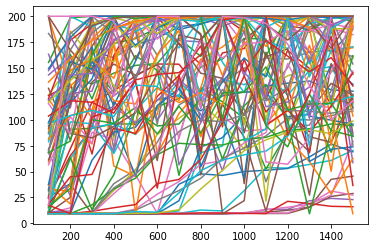

Group 1 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

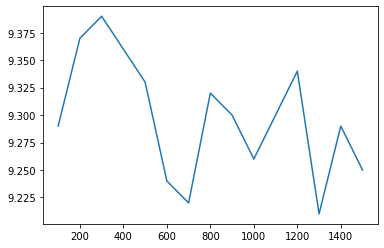

Group 2 / 21
There is 2 exemples fitting this group.


<AxesSubplot:>

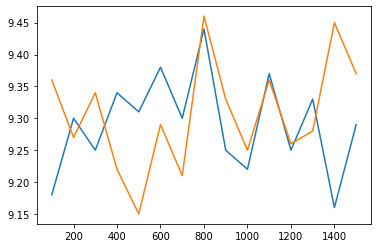

Group 3 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

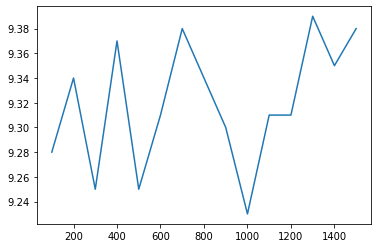

Group 4 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

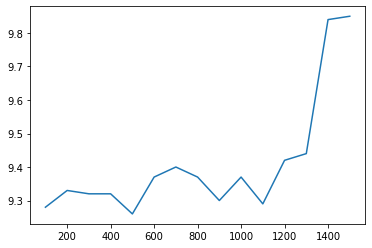

Group 5 / 21
There is 2 exemples fitting this group.


<AxesSubplot:>

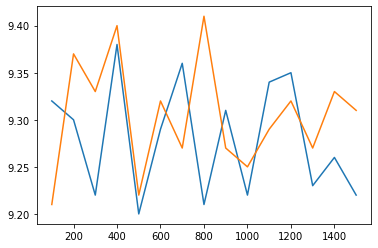

Group 6 / 21
There is 2 exemples fitting this group.


<AxesSubplot:>

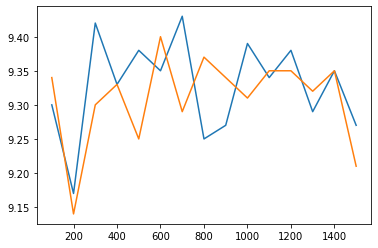

Group 7 / 21
There is 8 exemples fitting this group.


<AxesSubplot:>

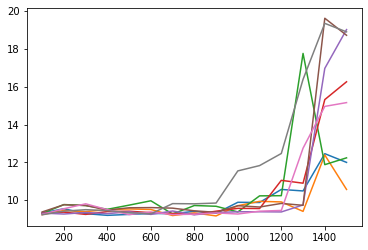

Group 8 / 21
There is 2 exemples fitting this group.


<AxesSubplot:>

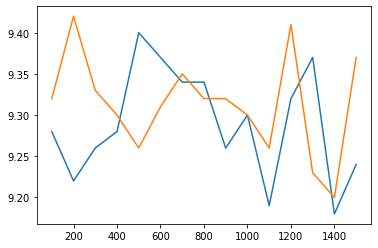

Group 9 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

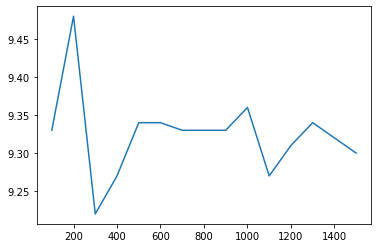

Group 10 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

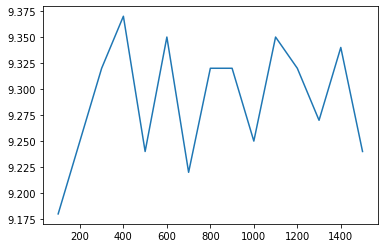

Group 11 / 21
There is 2 exemples fitting this group.


<AxesSubplot:>

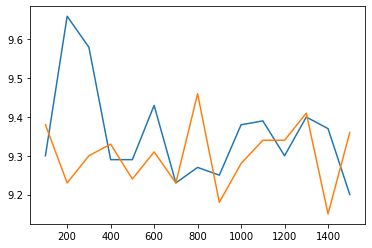

Group 12 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

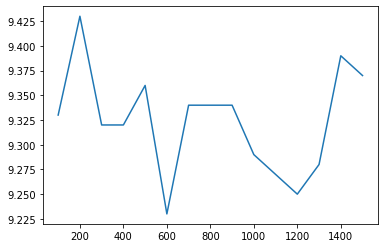

Group 13 / 21
There is 5 exemples fitting this group.


<AxesSubplot:>

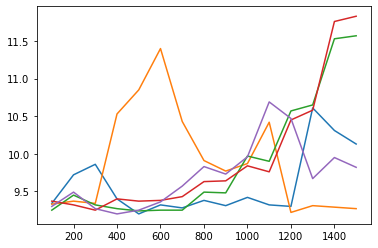

Group 14 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

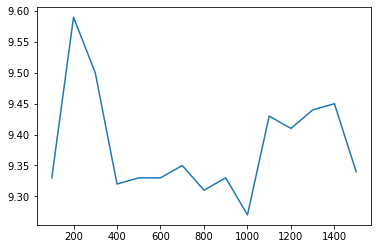

Group 15 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

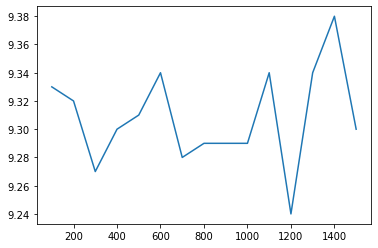

Group 16 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

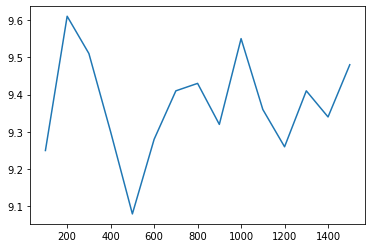

Group 17 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

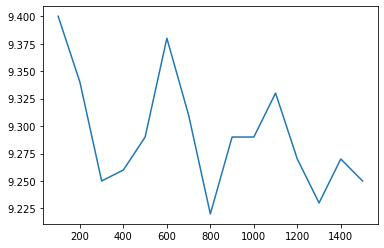

Group 18 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

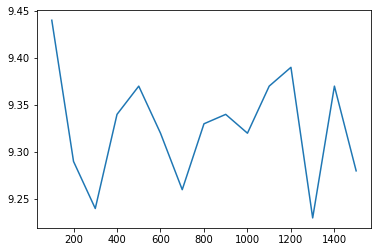

Group 19 / 21
There is 2 exemples fitting this group.


<AxesSubplot:>

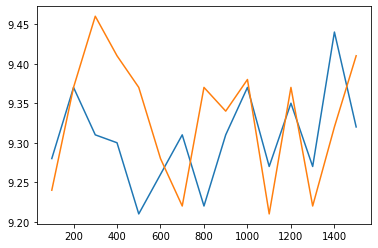

Group 20 / 21
There is 1 exemples fitting this group.


<AxesSubplot:>

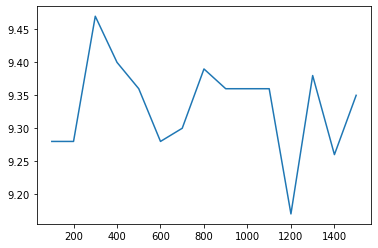

In [41]:
sim_from_data(x, y, 0)

Cov Mat <3 : 100%|██████████| 125/125 [01:21<00:00,  1.54line/s]


K is:  1
Sk is:  2
K is:  2
Sk is:  2
Sk is:  2
K is:  4
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  8
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  12
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  16
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Xmean created 25 clusters
Group 0 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

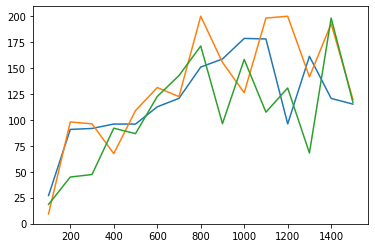

Group 1 / 25
There is 43 exemples fitting this group.


<AxesSubplot:>

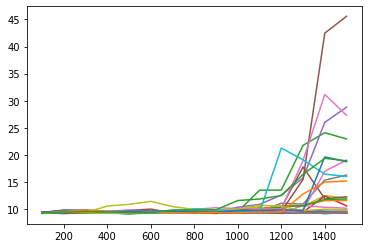

Group 2 / 25
There is 10 exemples fitting this group.


<AxesSubplot:>

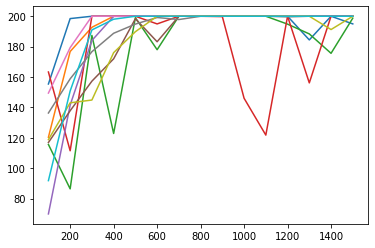

Group 3 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

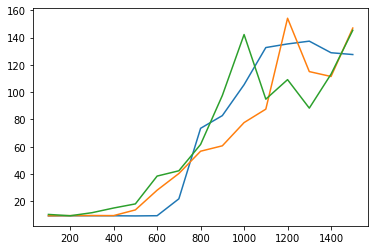

Group 4 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

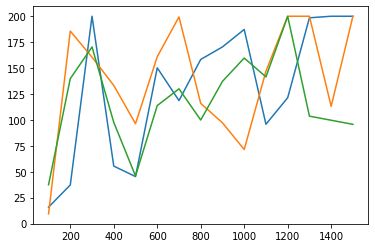

Group 5 / 25
There is 5 exemples fitting this group.


<AxesSubplot:>

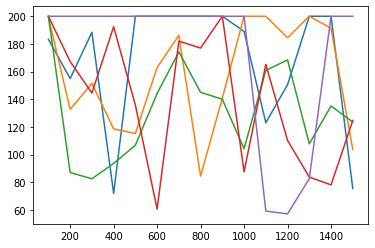

Group 6 / 25
There is 4 exemples fitting this group.


<AxesSubplot:>

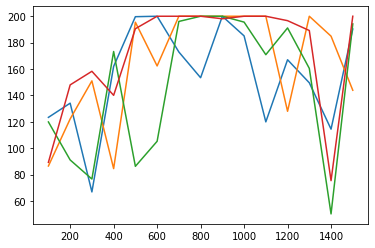

Group 7 / 25
There is 5 exemples fitting this group.


<AxesSubplot:>

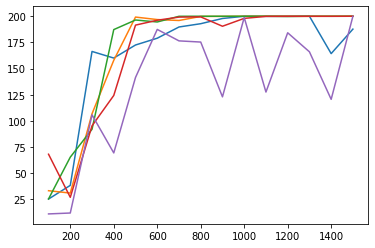

Group 8 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

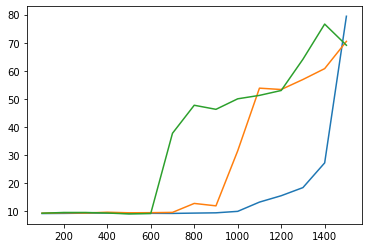

Group 9 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

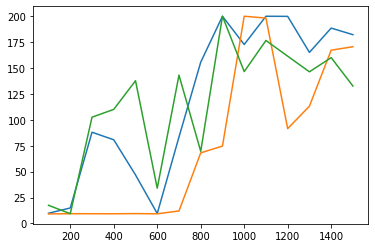

Group 10 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

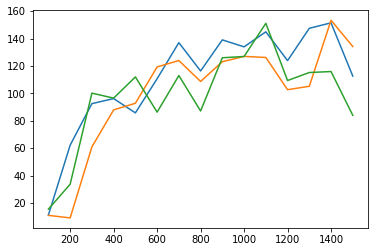

Group 11 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

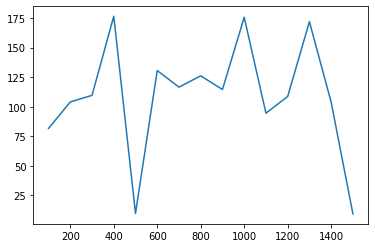

Group 12 / 25
There is 2 exemples fitting this group.


<AxesSubplot:>

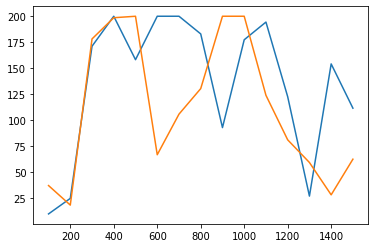

Group 13 / 25
There is 7 exemples fitting this group.


<AxesSubplot:>

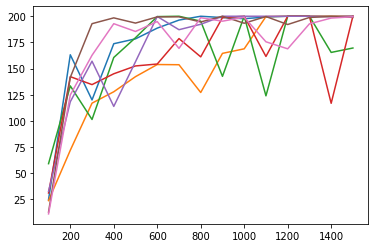

Group 14 / 25
There is 4 exemples fitting this group.


<AxesSubplot:>

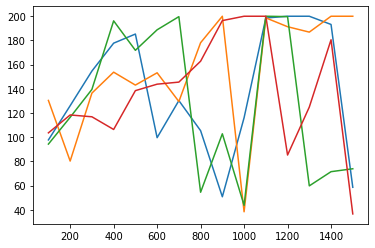

Group 15 / 25
There is 2 exemples fitting this group.


<AxesSubplot:>

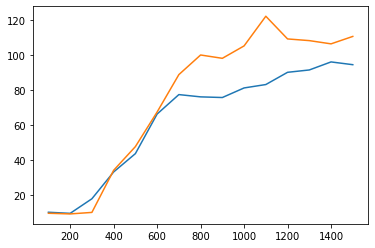

Group 16 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

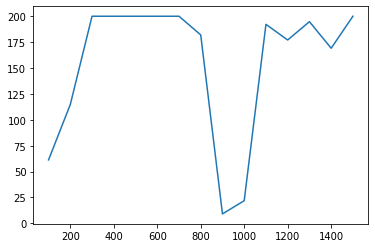

Group 17 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

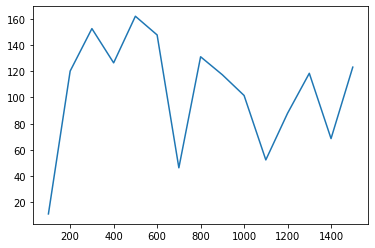

Group 18 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

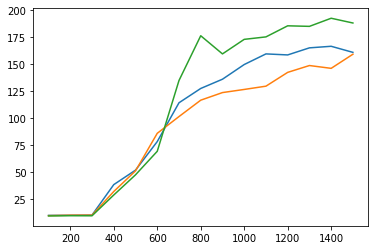

Group 19 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

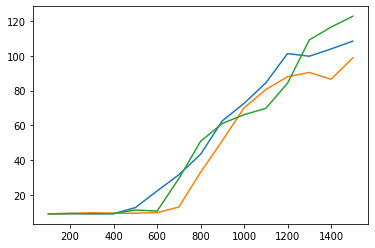

Group 20 / 25
There is 6 exemples fitting this group.


<AxesSubplot:>

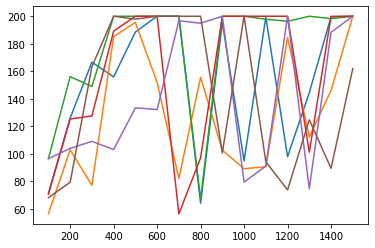

Group 21 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

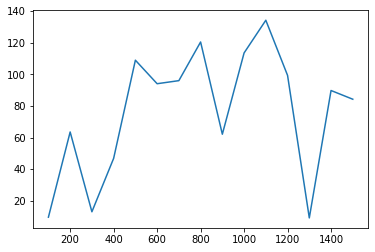

Group 22 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

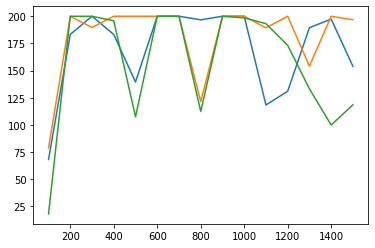

Group 23 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

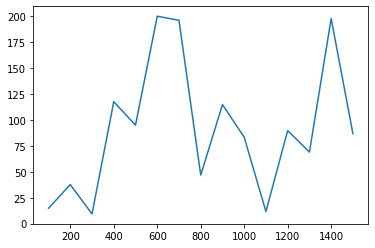

Group 24 / 25
There is 2 exemples fitting this group.


<AxesSubplot:>

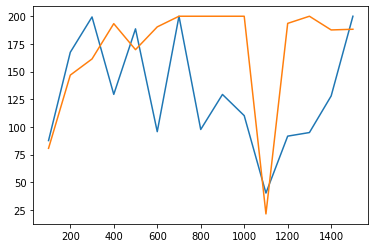

In [42]:
sim_from_data(x, y, 1)

Cov Mat <3 : 100%|██████████| 125/125 [01:27<00:00,  1.42line/s]


K is:  1
Sk is:  2
K is:  2
Sk is:  2
Sk is:  2
K is:  4
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  8
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  12
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  18
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Xmean created 23 clusters
Group 0 / 23
There is 44 exemples fitting this group.


<AxesSubplot:>

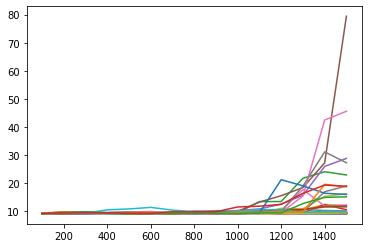

Group 1 / 23
There is 5 exemples fitting this group.


<AxesSubplot:>

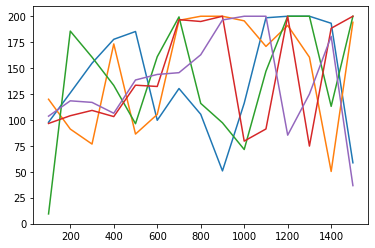

Group 2 / 23
There is 4 exemples fitting this group.


<AxesSubplot:>

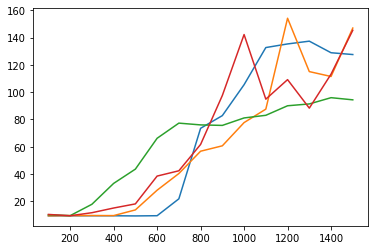

Group 3 / 23
There is 5 exemples fitting this group.


<AxesSubplot:>

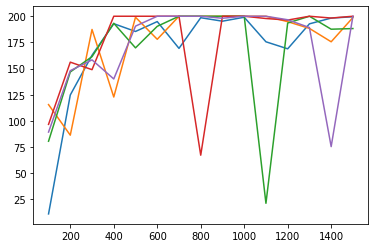

Group 4 / 23
There is 5 exemples fitting this group.


<AxesSubplot:>

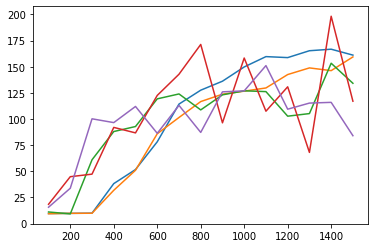

Group 5 / 23
There is 5 exemples fitting this group.


<AxesSubplot:>

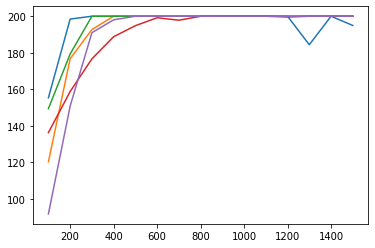

Group 6 / 23
There is 10 exemples fitting this group.


<AxesSubplot:>

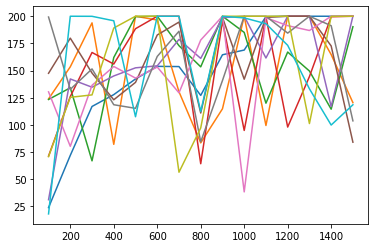

Group 7 / 23
There is 2 exemples fitting this group.


<AxesSubplot:>

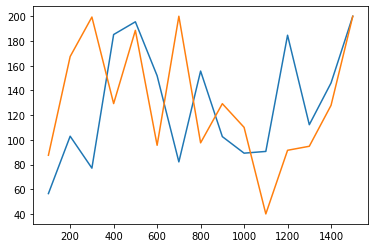

Group 8 / 23
There is 2 exemples fitting this group.


<AxesSubplot:>

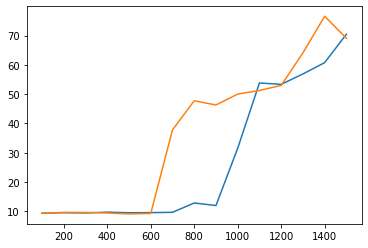

Group 9 / 23
There is 2 exemples fitting this group.


<AxesSubplot:>

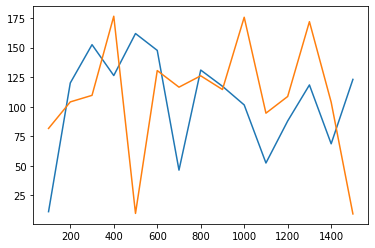

Group 10 / 23
There is 3 exemples fitting this group.


<AxesSubplot:>

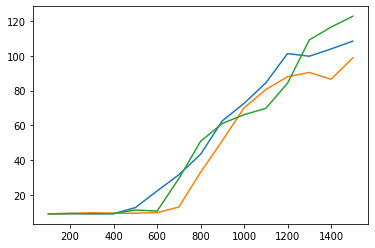

Group 11 / 23
There is 3 exemples fitting this group.


<AxesSubplot:>

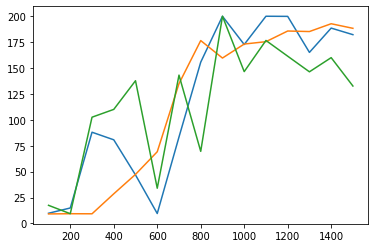

Group 12 / 23
There is 2 exemples fitting this group.


<AxesSubplot:>

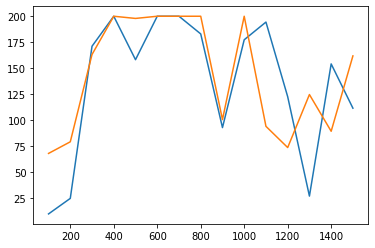

Group 13 / 23
There is 1 exemples fitting this group.


<AxesSubplot:>

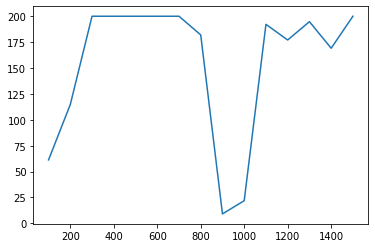

Group 14 / 23
There is 1 exemples fitting this group.


<AxesSubplot:>

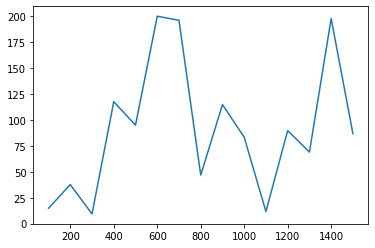

Group 15 / 23
There is 4 exemples fitting this group.


<AxesSubplot:>

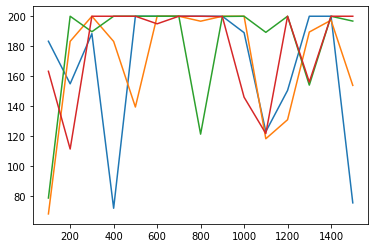

Group 16 / 23
There is 5 exemples fitting this group.


<AxesSubplot:>

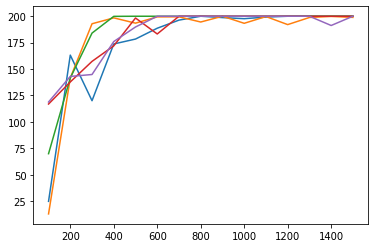

Group 17 / 23
There is 3 exemples fitting this group.


<AxesSubplot:>

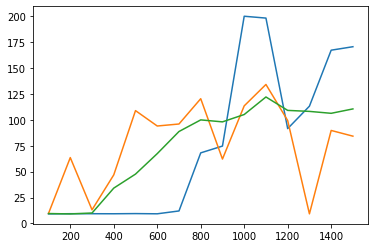

Group 18 / 23
There is 7 exemples fitting this group.


<AxesSubplot:>

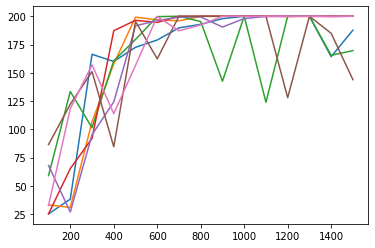

Group 19 / 23
There is 4 exemples fitting this group.


<AxesSubplot:>

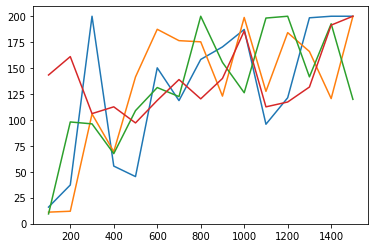

Group 20 / 23
There is 2 exemples fitting this group.


<AxesSubplot:>

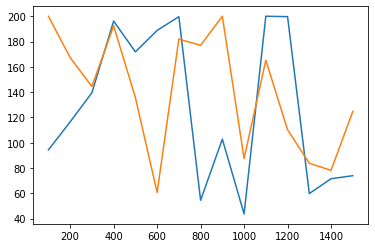

Group 21 / 23
There is 1 exemples fitting this group.


<AxesSubplot:>

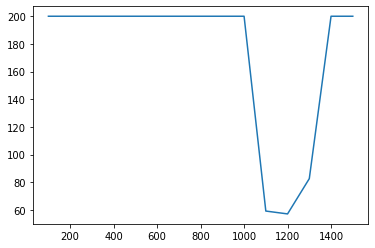

Group 22 / 23
There is 1 exemples fitting this group.


<AxesSubplot:>

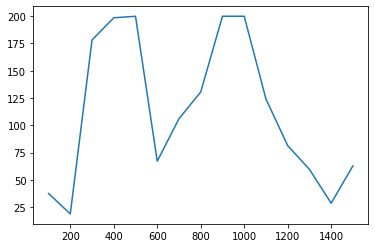

In [43]:
sim_from_data(x, y, 2)

Cov Mat <3 : 100%|██████████| 125/125 [00:10<00:00, 11.80line/s]


K is:  1
Sk is:  2
K is:  2
Sk is:  2
Sk is:  2
K is:  4
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  7
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  13
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  19
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Xmean created 25 clusters
Group 0 / 25
There is 7 exemples fitting this group.


<AxesSubplot:>

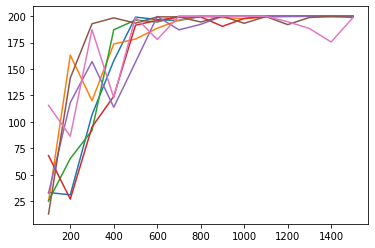

Group 1 / 25
There is 25 exemples fitting this group.


<AxesSubplot:>

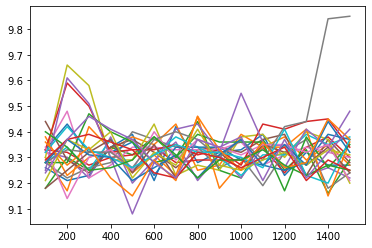

Group 2 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

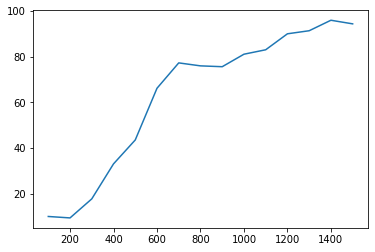

Group 3 / 25
There is 4 exemples fitting this group.


<AxesSubplot:>

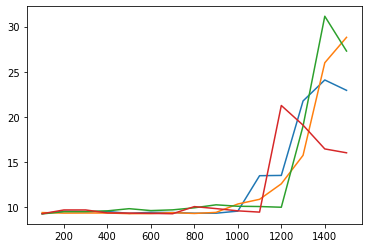

Group 4 / 25
There is 6 exemples fitting this group.


<AxesSubplot:>

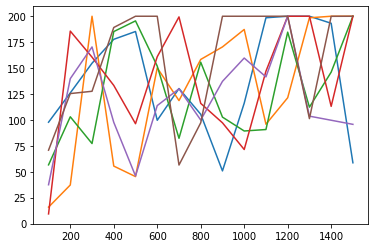

Group 5 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

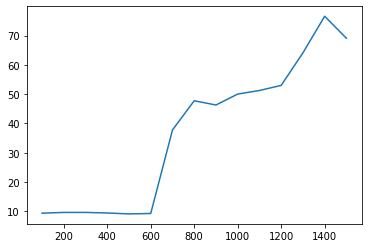

Group 6 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

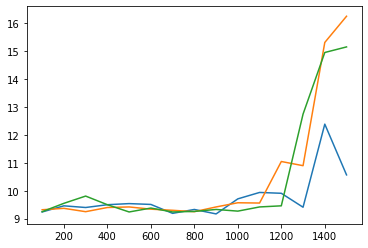

Group 7 / 25
There is 13 exemples fitting this group.


<AxesSubplot:>

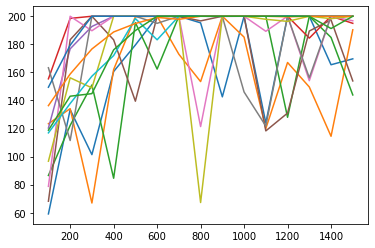

Group 8 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

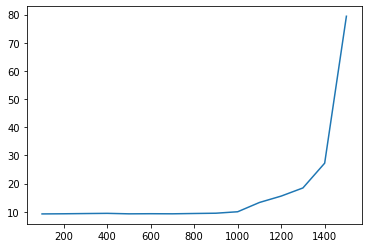

Group 9 / 25
There is 4 exemples fitting this group.


<AxesSubplot:>

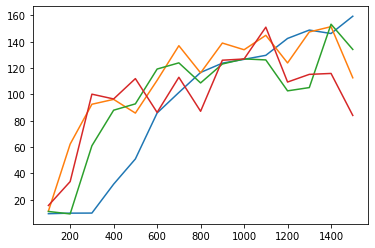

Group 10 / 25
There is 4 exemples fitting this group.


<AxesSubplot:>

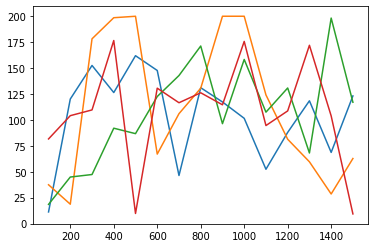

Group 11 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

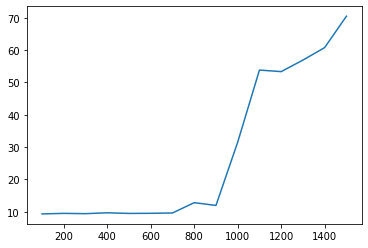

Group 12 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

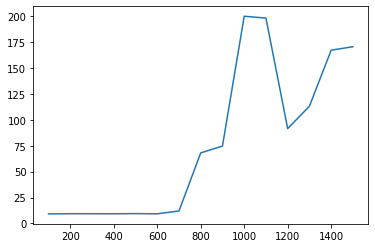

Group 13 / 25
There is 2 exemples fitting this group.


<AxesSubplot:>

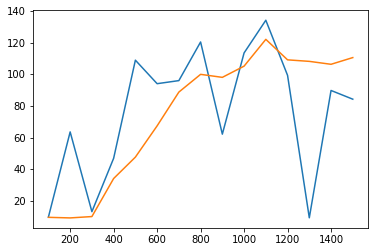

Group 14 / 25
There is 6 exemples fitting this group.


<AxesSubplot:>

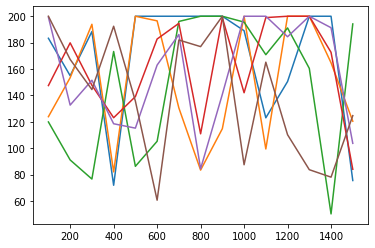

Group 15 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

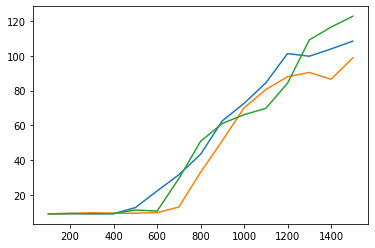

Group 16 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

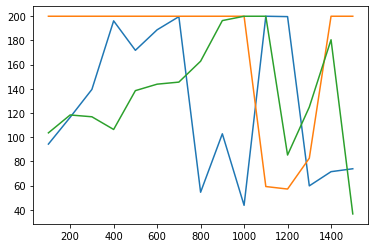

Group 17 / 25
There is 4 exemples fitting this group.


<AxesSubplot:>

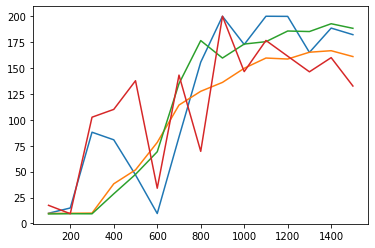

Group 18 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

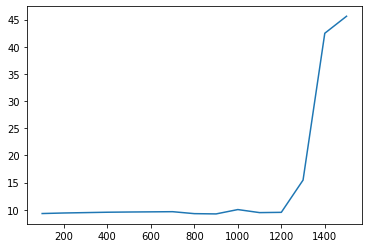

Group 19 / 25
There is 4 exemples fitting this group.


<AxesSubplot:>

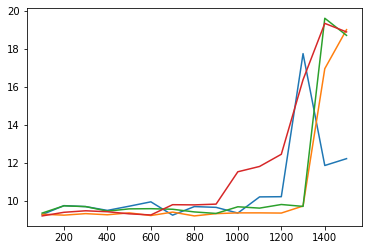

Group 20 / 25
There is 6 exemples fitting this group.


<AxesSubplot:>

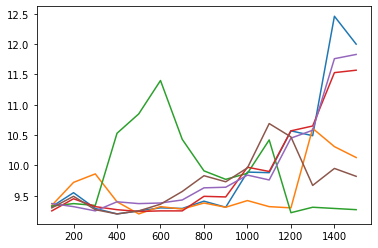

Group 21 / 25
There is 6 exemples fitting this group.


<AxesSubplot:>

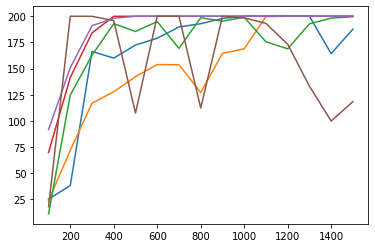

Group 22 / 25
There is 6 exemples fitting this group.


<AxesSubplot:>

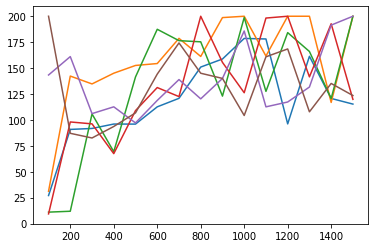

Group 23 / 25
There is 1 exemples fitting this group.


<AxesSubplot:>

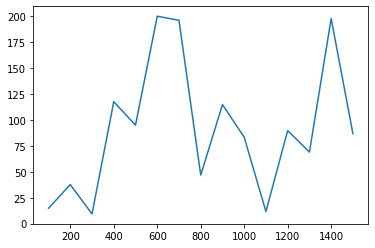

Group 24 / 25
There is 3 exemples fitting this group.


<AxesSubplot:>

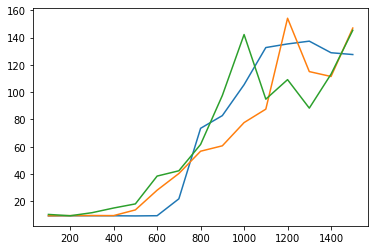

In [40]:
sim_from_data(x, y, 3)

Cov Mat <3 : 100%|██████████| 125/125 [00:08<00:00, 14.68line/s]


K is:  1
Sk is:  2
K is:  2
Sk is:  2
Sk is:  2
K is:  4
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  7
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  11
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  14
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
K is:  19
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Sk is:  2
Xmean created 26 clusters
Group 0 / 26
There is 7 exemples fitting this group.


<AxesSubplot:>

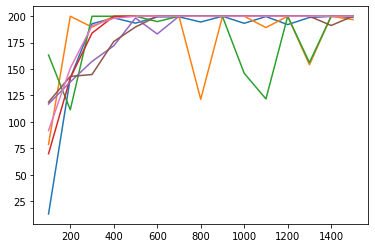

Group 1 / 26
There is 7 exemples fitting this group.


<AxesSubplot:>

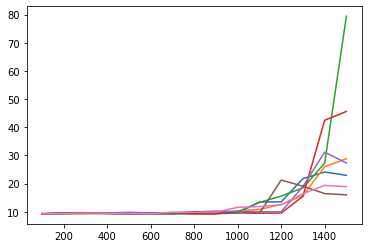

Group 2 / 26
There is 2 exemples fitting this group.


<AxesSubplot:>

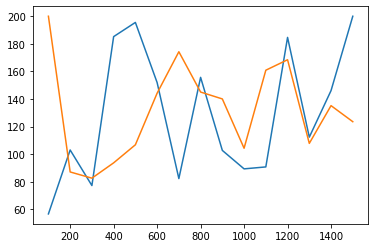

Group 3 / 26
There is 1 exemples fitting this group.


<AxesSubplot:>

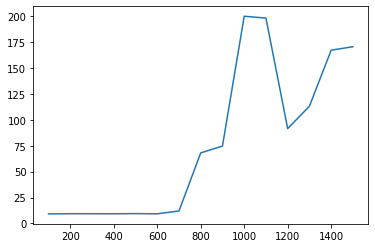

Group 4 / 26
There is 5 exemples fitting this group.


<AxesSubplot:>

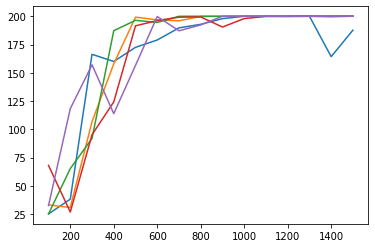

Group 5 / 26
There is 4 exemples fitting this group.


<AxesSubplot:>

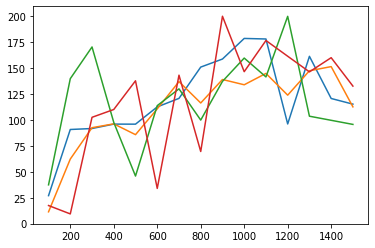

Group 6 / 26
There is 4 exemples fitting this group.


<AxesSubplot:>

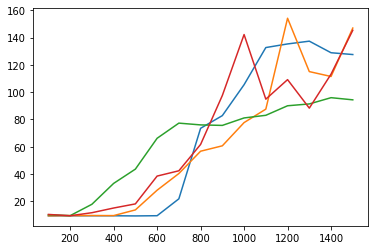

Group 7 / 26
There is 4 exemples fitting this group.


<AxesSubplot:>

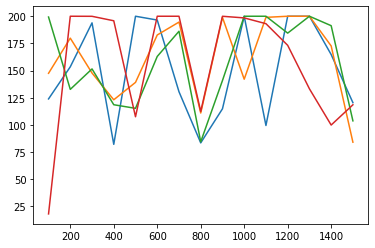

Group 8 / 26
There is 2 exemples fitting this group.


<AxesSubplot:>

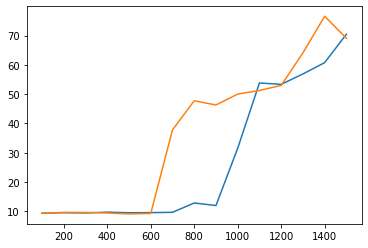

Group 9 / 26
There is 5 exemples fitting this group.


<AxesSubplot:>

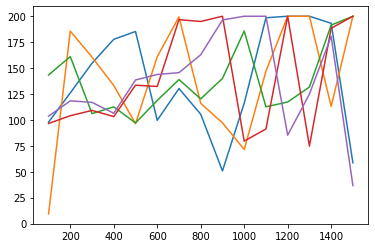

Group 10 / 26
There is 2 exemples fitting this group.


<AxesSubplot:>

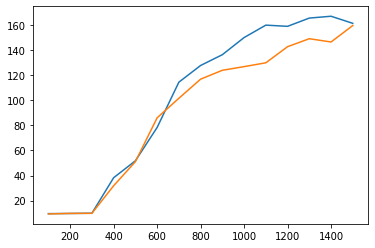

Group 11 / 26
There is 1 exemples fitting this group.


<AxesSubplot:>

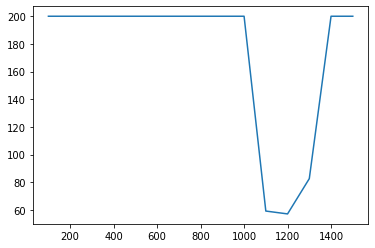

Group 12 / 26
There is 5 exemples fitting this group.


<AxesSubplot:>

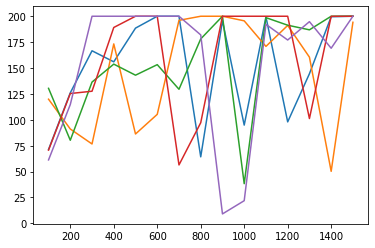

Group 13 / 26
There is 3 exemples fitting this group.


<AxesSubplot:>

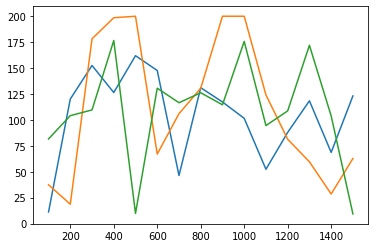

Group 14 / 26
There is 37 exemples fitting this group.


<AxesSubplot:>

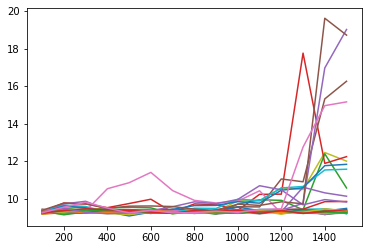

Group 15 / 26
There is 3 exemples fitting this group.


<AxesSubplot:>

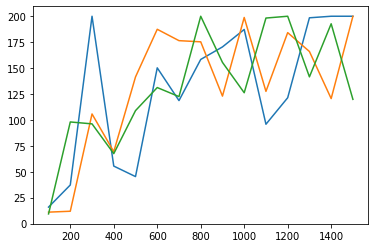

Group 16 / 26
There is 2 exemples fitting this group.


<AxesSubplot:>

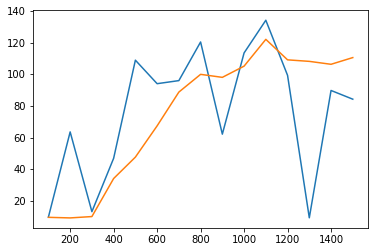

Group 17 / 26
There is 6 exemples fitting this group.


<AxesSubplot:>

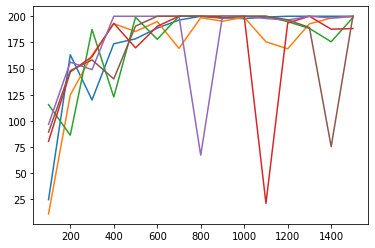

Group 18 / 26
There is 3 exemples fitting this group.


<AxesSubplot:>

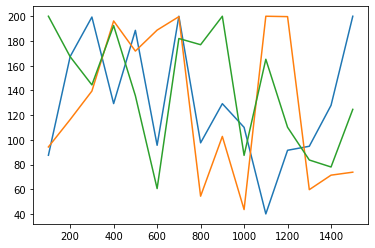

Group 19 / 26
There is 3 exemples fitting this group.


<AxesSubplot:>

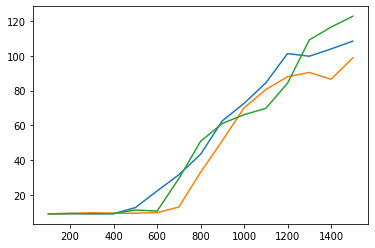

Group 20 / 26
There is 5 exemples fitting this group.


<AxesSubplot:>

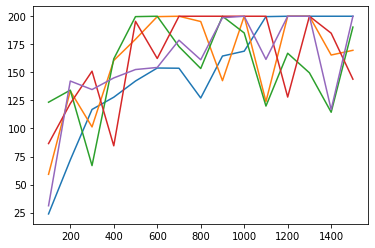

Group 21 / 26
There is 1 exemples fitting this group.


<AxesSubplot:>

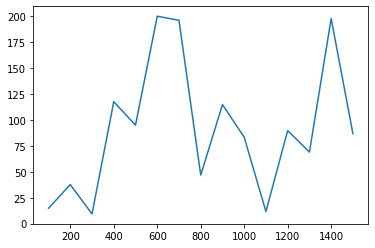

Group 22 / 26
There is 3 exemples fitting this group.


<AxesSubplot:>

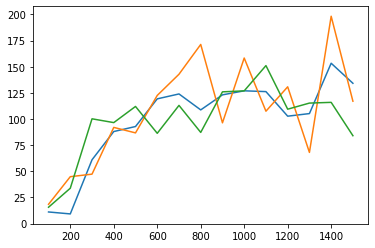

Group 23 / 26
There is 2 exemples fitting this group.


<AxesSubplot:>

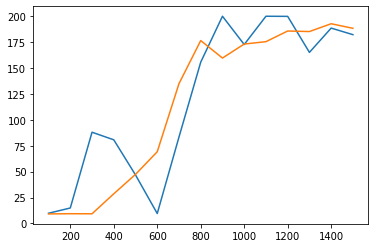

Group 24 / 26
There is 2 exemples fitting this group.


<AxesSubplot:>

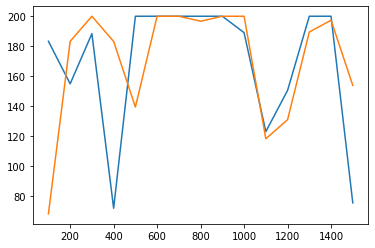

Group 25 / 26
There is 4 exemples fitting this group.


<AxesSubplot:>

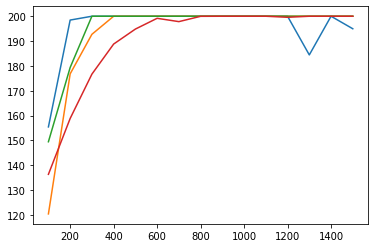

In [44]:
sim_from_data(x, y, 4)

## Instability measure

In [86]:
def instability_val(x, mark, step=1):
    instability = []
    hmm = 0
    for curve, m in zip(x, mark):
        val = 0
        for i in range(step, len(curve)):
            tmp = curve[i] - curve[i - step]
            if tmp < 0:
                val += tmp
        instability.append([curve, m, val, hmm])
        hmm += 1
    return instability

instability = instability_val(y, x)

In [87]:
instability.sort(key=lambda x: x[2])

x_ = [x[1] for x in instability]
y_ = [x[0] for x in instability]
i_ = [x[3] for x in instability]


Curve n*48


<AxesSubplot:>

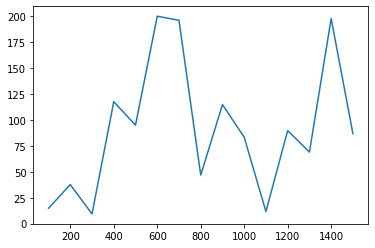

Curve n*99


<AxesSubplot:>

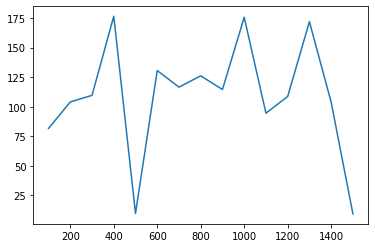

Curve n*29


<AxesSubplot:>

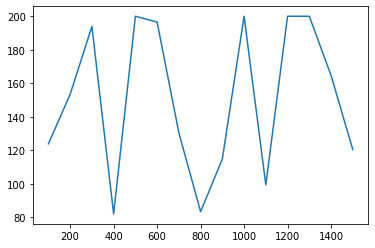

Curve n*103


<AxesSubplot:>

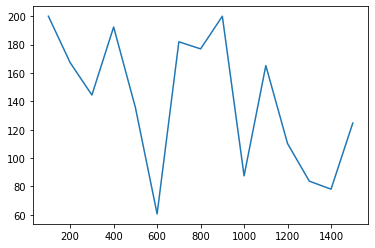

Curve n*88


<AxesSubplot:>

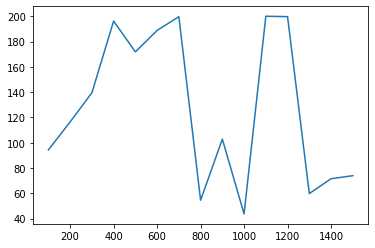

Curve n*71


<AxesSubplot:>

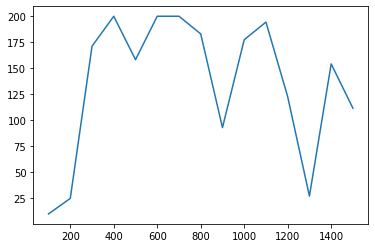

Curve n*73


<AxesSubplot:>

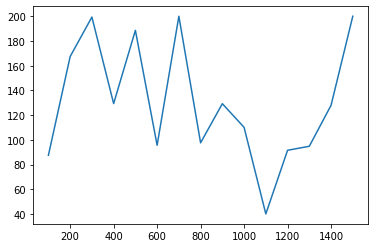

Curve n*61


<AxesSubplot:>

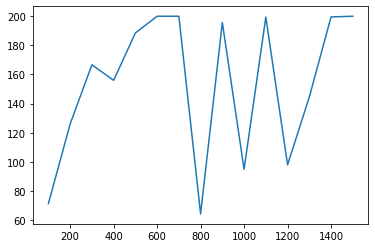

Curve n*28


<AxesSubplot:>

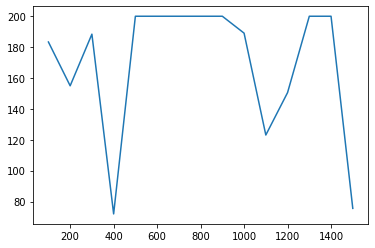

Curve n*79


<AxesSubplot:>

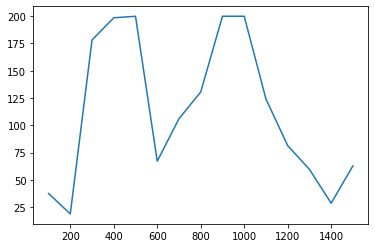

Curve n*89


<AxesSubplot:>

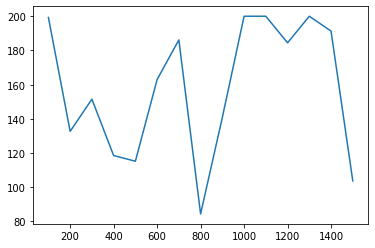

Curve n*82


<AxesSubplot:>

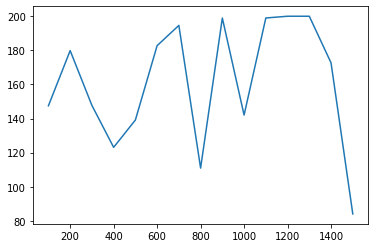

Curve n*45


<AxesSubplot:>

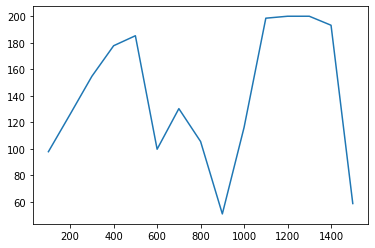

Curve n*74


<AxesSubplot:>

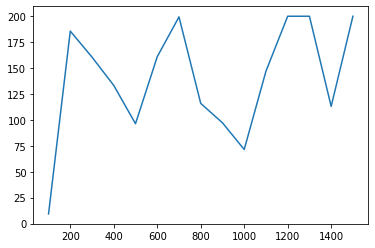

Curve n*64


<AxesSubplot:>

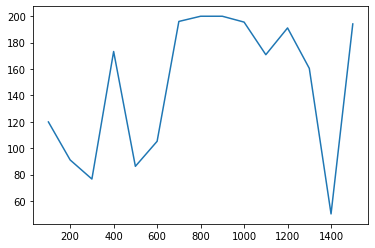

Curve n*111


<AxesSubplot:>

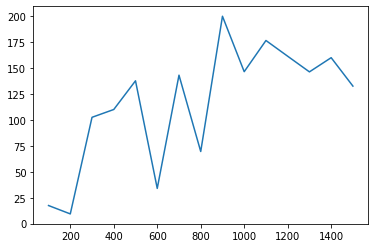

Curve n*124


<AxesSubplot:>

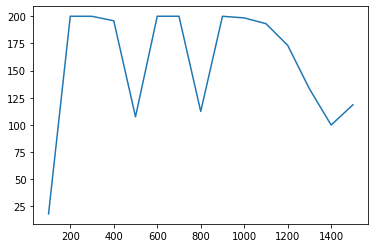

Curve n*72


<AxesSubplot:>

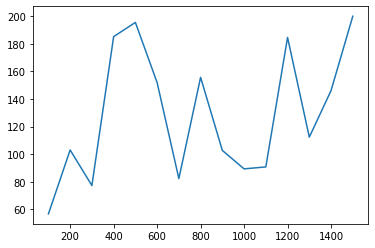

Curve n*54


<AxesSubplot:>

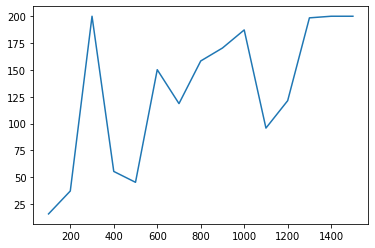

Curve n*98


<AxesSubplot:>

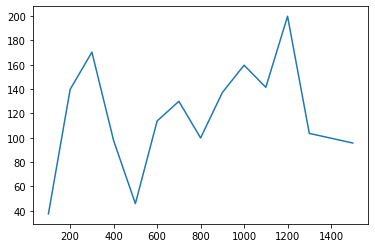

Curve n*91


<AxesSubplot:>

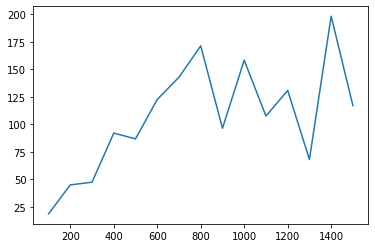

Curve n*121


<AxesSubplot:>

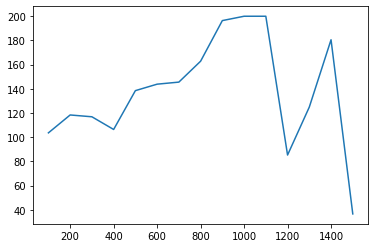

Curve n*55


<AxesSubplot:>

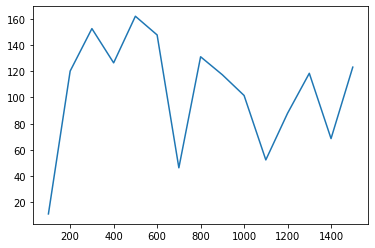

Curve n*120


<AxesSubplot:>

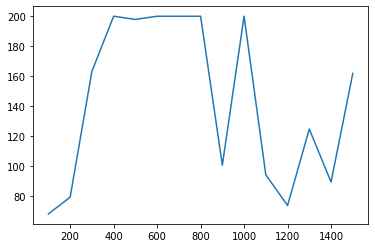

Curve n*93


<AxesSubplot:>

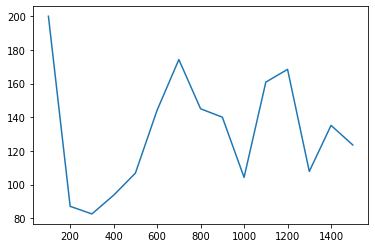

Curve n*83


<AxesSubplot:>

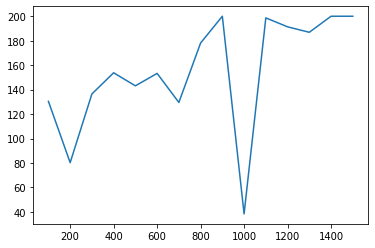

Curve n*117


<AxesSubplot:>

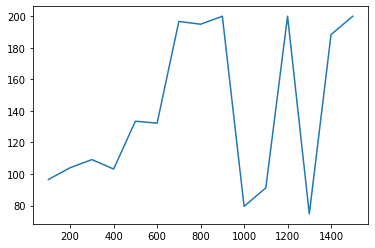

Curve n*90


<AxesSubplot:>

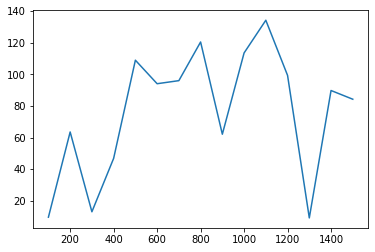

Curve n*44


<AxesSubplot:>

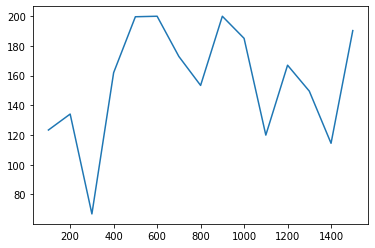

Curve n*75


<AxesSubplot:>

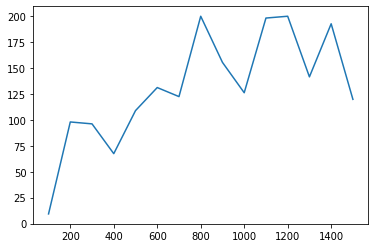

Curve n*112


<AxesSubplot:>

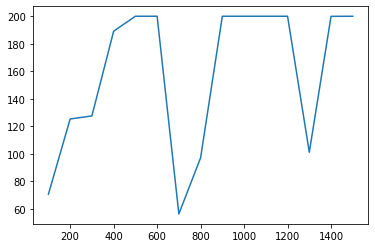

Curve n*70


<AxesSubplot:>

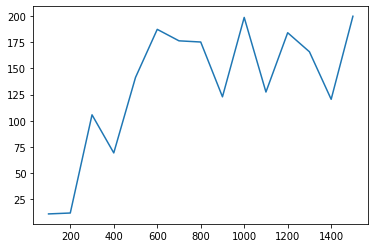

Curve n*113


<AxesSubplot:>

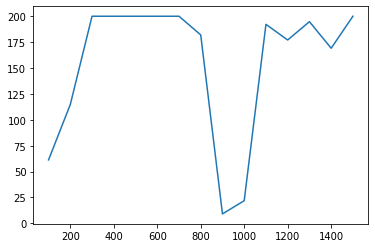

Curve n*60


<AxesSubplot:>

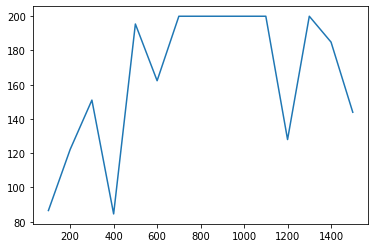

Curve n*96


<AxesSubplot:>

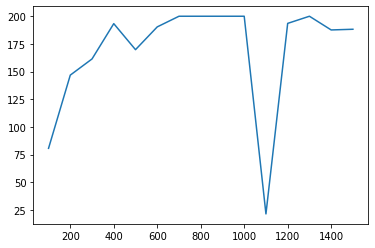

Curve n*38


<AxesSubplot:>

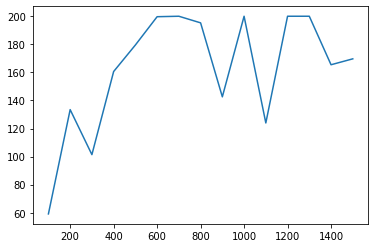

Curve n*95


<AxesSubplot:>

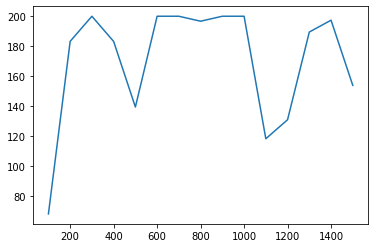

Curve n*102


<AxesSubplot:>

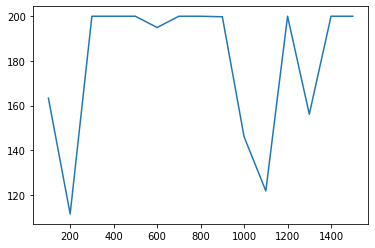

Curve n*92


<AxesSubplot:>

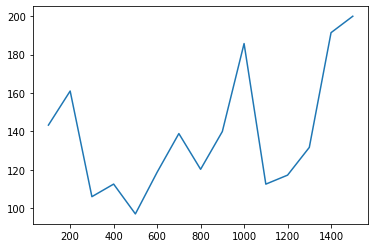

Curve n*97


<AxesSubplot:>

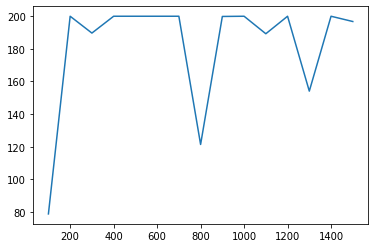

Curve n*49


<AxesSubplot:>

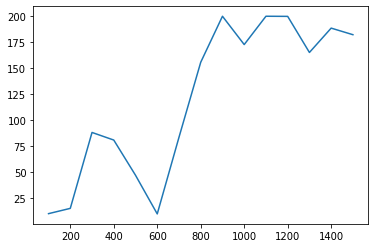

Curve n*65


<AxesSubplot:>

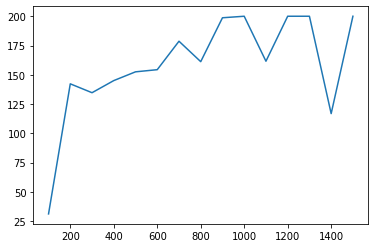

Curve n*108


<AxesSubplot:>

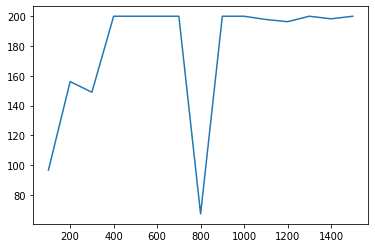

Curve n*109


<AxesSubplot:>

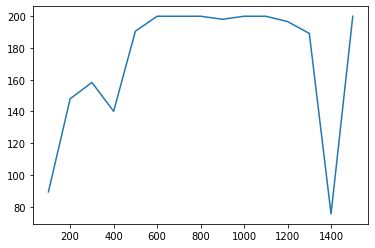

Curve n*114


<AxesSubplot:>

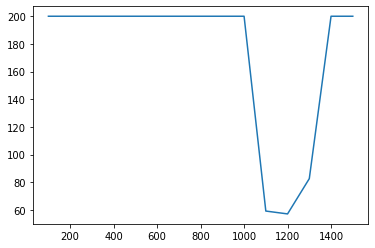

Curve n*94


<AxesSubplot:>

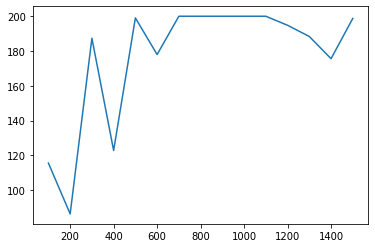

Curve n*110


<AxesSubplot:>

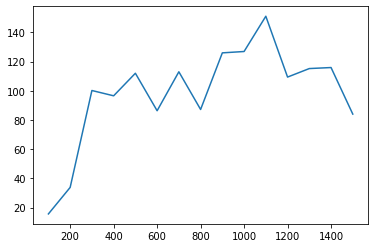

Curve n*39


<AxesSubplot:>

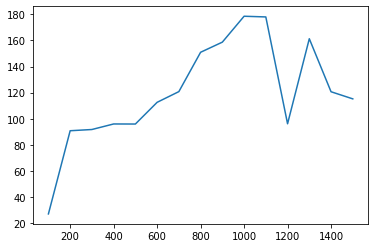

Curve n*52


<AxesSubplot:>

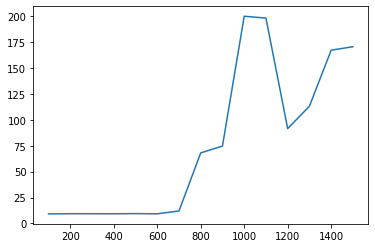

Curve n*62


<AxesSubplot:>

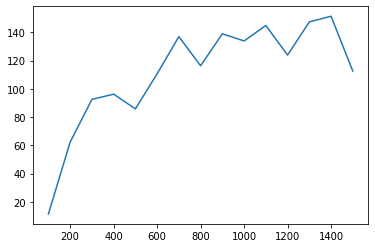

Curve n*101


<AxesSubplot:>

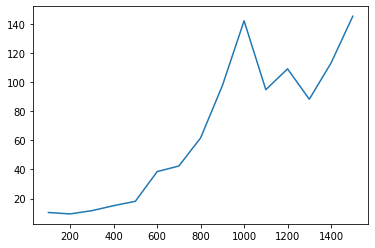

Curve n*87


<AxesSubplot:>

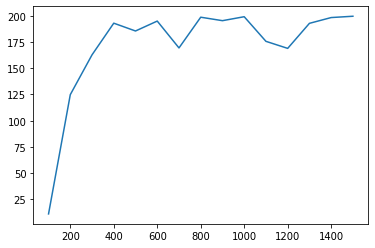

Curve n*63


<AxesSubplot:>

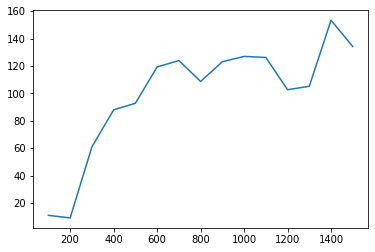

Curve n*78


<AxesSubplot:>

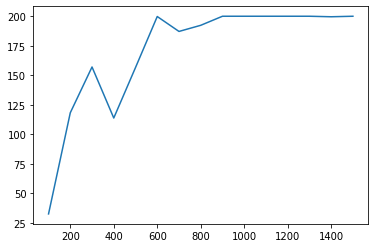

Curve n*57


<AxesSubplot:>

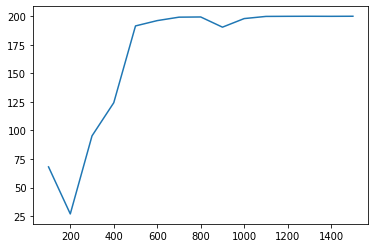

Curve n*10


<AxesSubplot:>

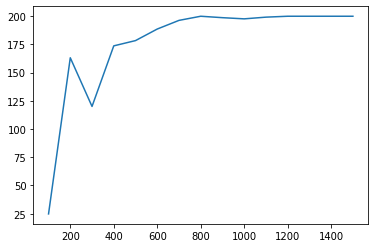

Curve n*84


<AxesSubplot:>

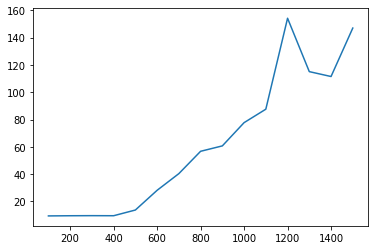

Curve n*4


<AxesSubplot:>

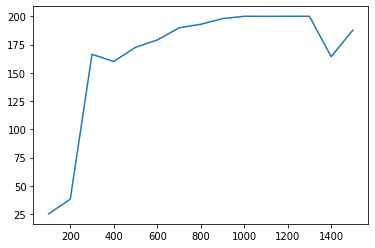

Curve n*11


<AxesSubplot:>

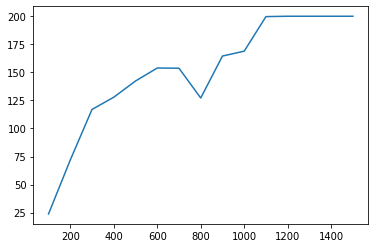

Curve n*86


<AxesSubplot:>

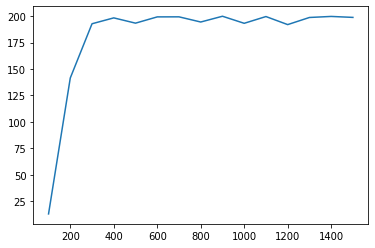

Curve n*104


<AxesSubplot:>

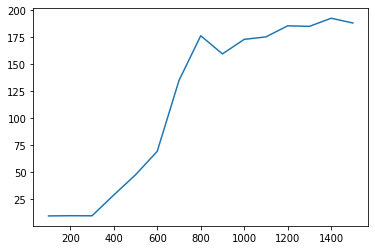

Curve n*80


<AxesSubplot:>

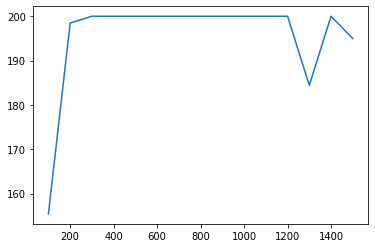

Curve n*105


<AxesSubplot:>

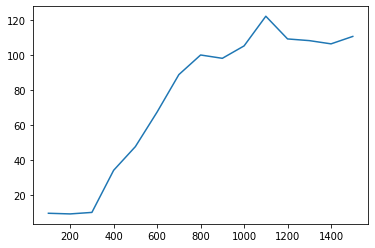

Curve n*116


<AxesSubplot:>

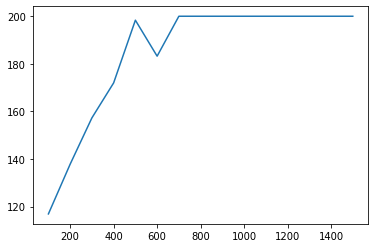

Curve n*53


<AxesSubplot:>

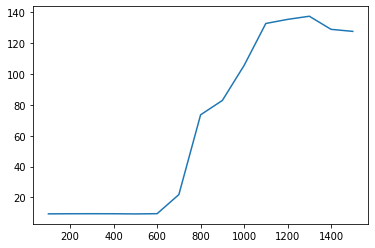

Curve n*35


<AxesSubplot:>

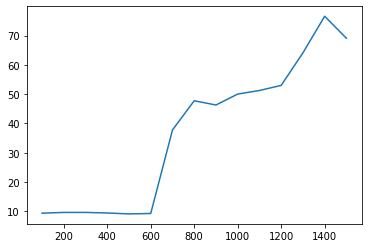

Curve n*122


<AxesSubplot:>

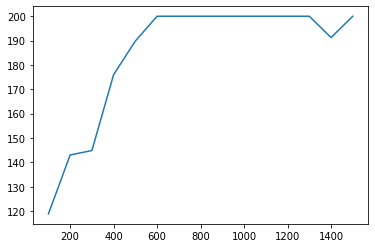

Curve n*20


<AxesSubplot:>

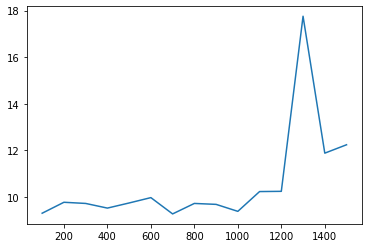

Curve n*50


<AxesSubplot:>

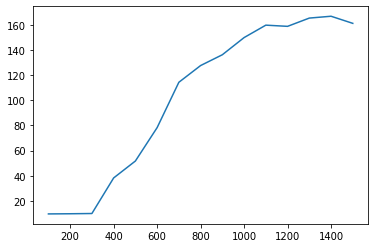

Curve n*68


<AxesSubplot:>

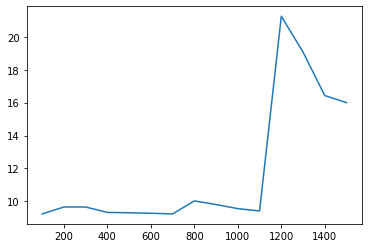

Curve n*5


<AxesSubplot:>

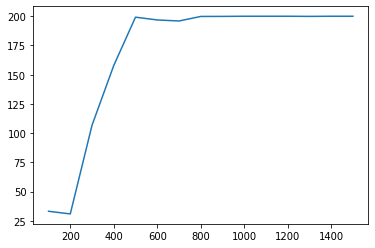

Curve n*59


<AxesSubplot:>

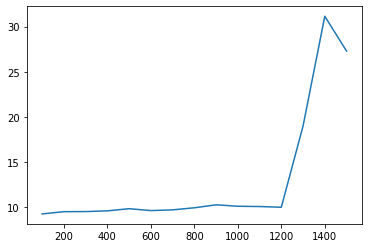

Curve n*106


<AxesSubplot:>

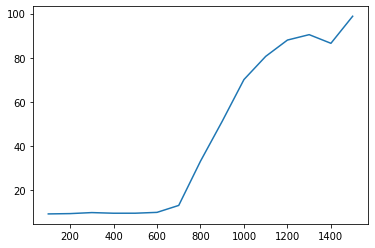

Curve n*100


<AxesSubplot:>

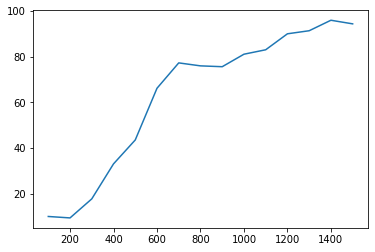

Curve n*17


<AxesSubplot:>

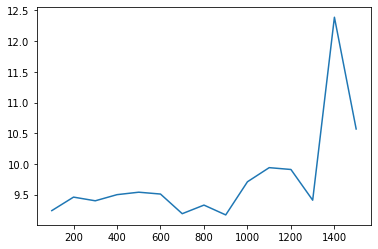

Curve n*23


<AxesSubplot:>

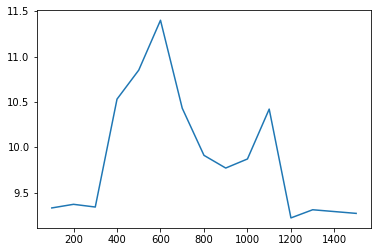

Curve n*51


<AxesSubplot:>

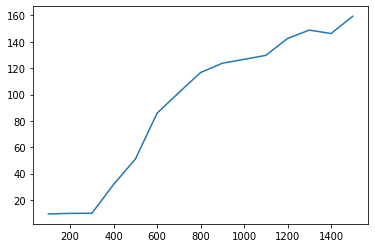

Curve n*56


<AxesSubplot:>

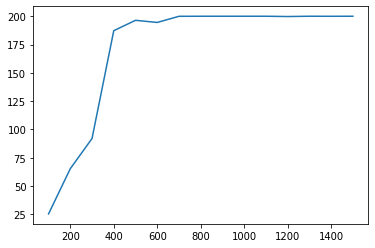

Curve n*119


<AxesSubplot:>

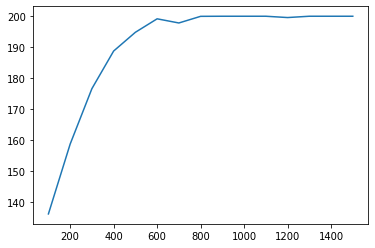

Curve n*34


<AxesSubplot:>

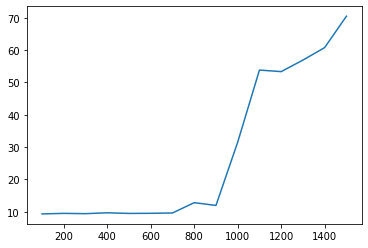

Curve n*85


<AxesSubplot:>

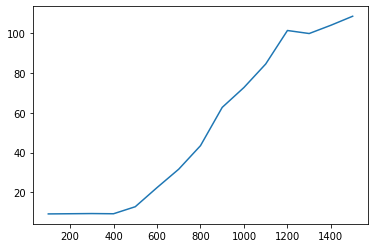

Curve n*69


<AxesSubplot:>

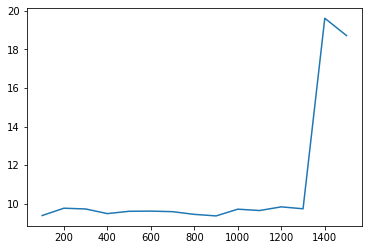

Curve n*67


<AxesSubplot:>

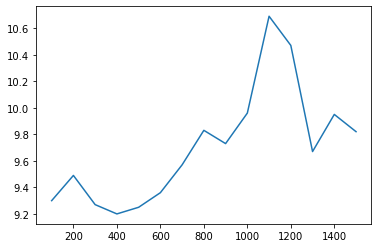

Curve n*16


<AxesSubplot:>

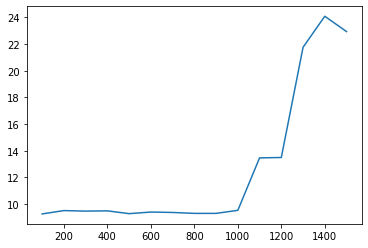

Curve n*21


<AxesSubplot:>

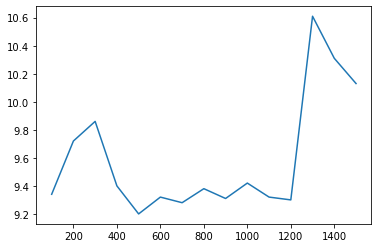

Curve n*12


<AxesSubplot:>

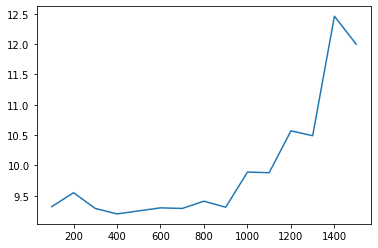

Curve n*27


<AxesSubplot:>

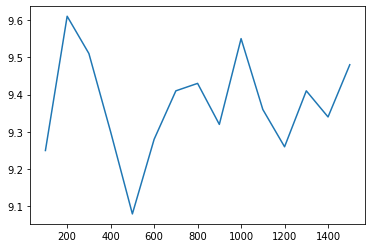

Curve n*58


<AxesSubplot:>

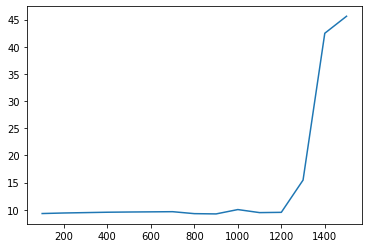

Curve n*107


<AxesSubplot:>

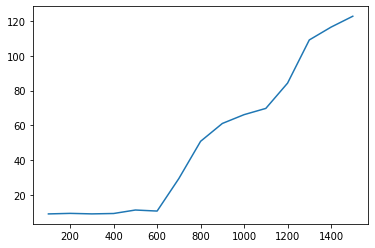

Curve n*13


<AxesSubplot:>

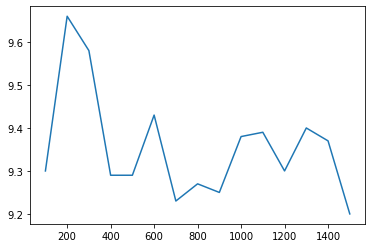

Curve n*24


<AxesSubplot:>

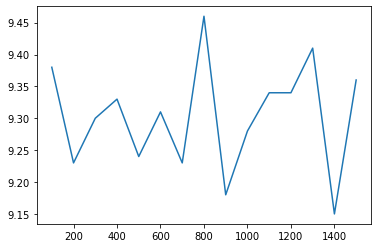

Curve n*76


<AxesSubplot:>

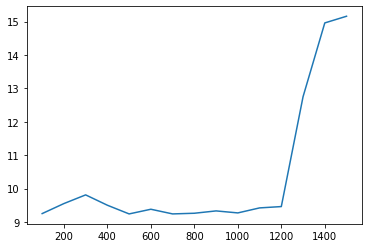

Curve n*41


<AxesSubplot:>

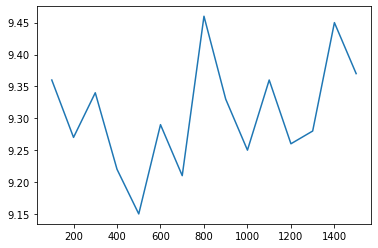

Curve n*77


<AxesSubplot:>

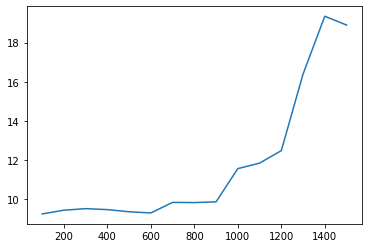

Curve n*6


<AxesSubplot:>

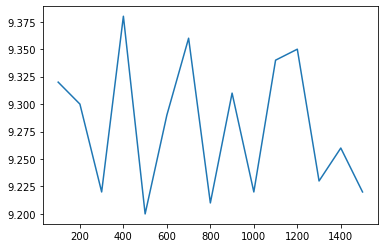

Curve n*2


<AxesSubplot:>

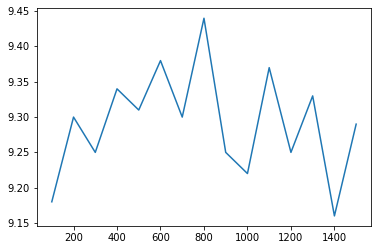

Curve n*1


<AxesSubplot:>

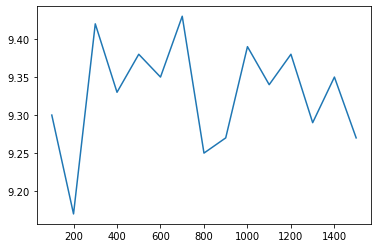

Curve n*31


<AxesSubplot:>

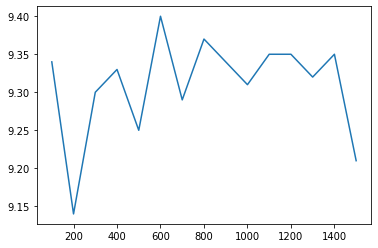

Curve n*66


<AxesSubplot:>

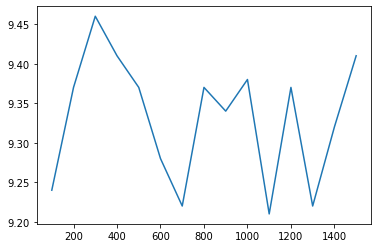

Curve n*0


<AxesSubplot:>

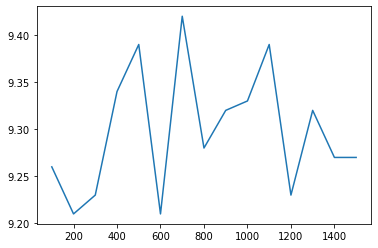

Curve n*7


<AxesSubplot:>

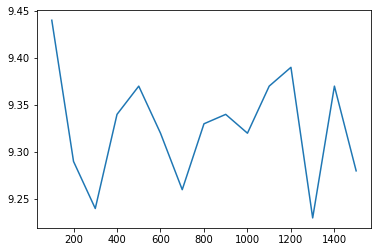

Curve n*40


<AxesSubplot:>

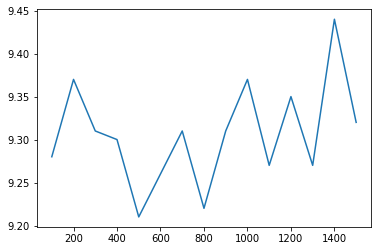

Curve n*25


<AxesSubplot:>

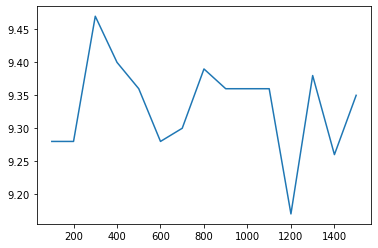

Curve n*30


<AxesSubplot:>

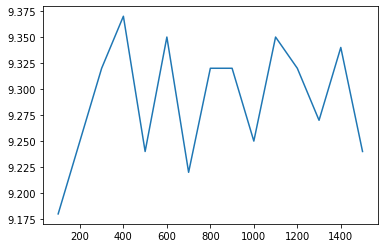

Curve n*9


<AxesSubplot:>

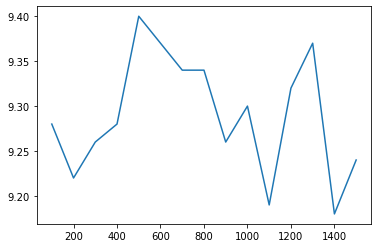

Curve n*36


<AxesSubplot:>

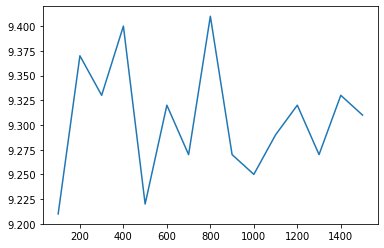

Curve n*26


<AxesSubplot:>

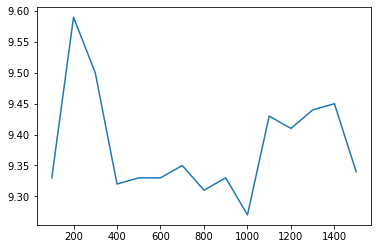

Curve n*33


<AxesSubplot:>

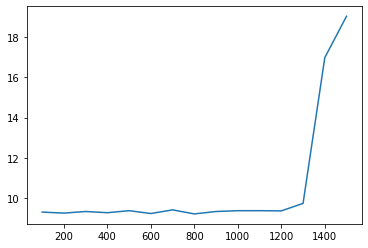

Curve n*37


<AxesSubplot:>

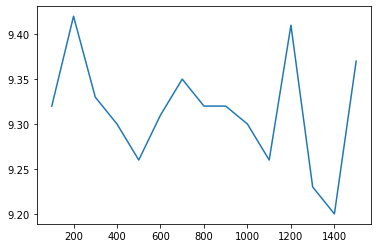

Curve n*22


<AxesSubplot:>

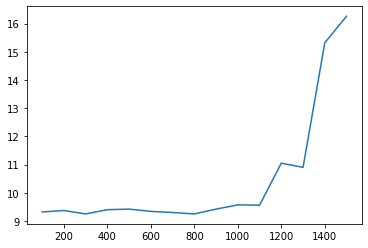

Curve n*46


<AxesSubplot:>

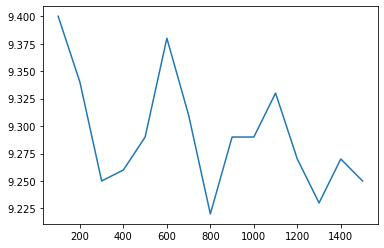

Curve n*14


<AxesSubplot:>

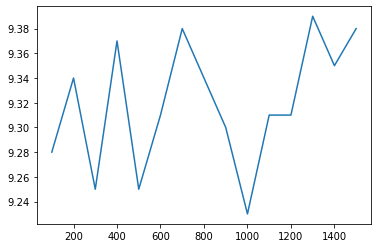

Curve n*8


<AxesSubplot:>

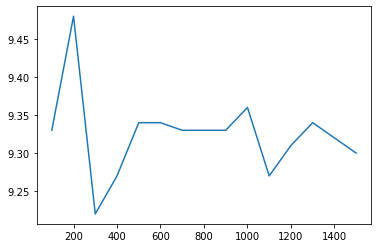

Curve n*47


<AxesSubplot:>

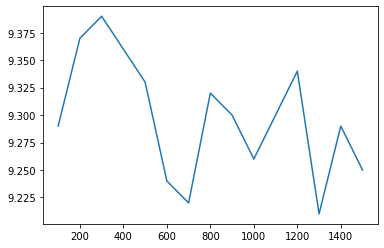

Curve n*15


<AxesSubplot:>

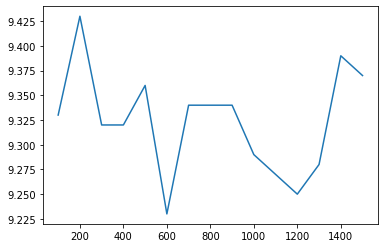

Curve n*3


<AxesSubplot:>

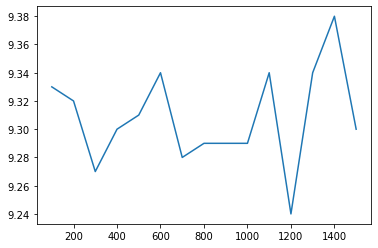

Curve n*42


<AxesSubplot:>

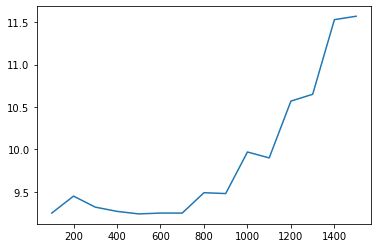

Curve n*32


<AxesSubplot:>

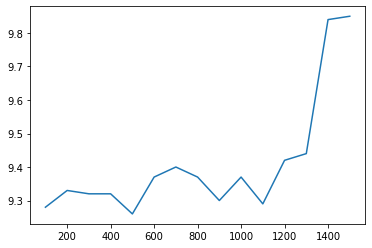

Curve n*43


<AxesSubplot:>

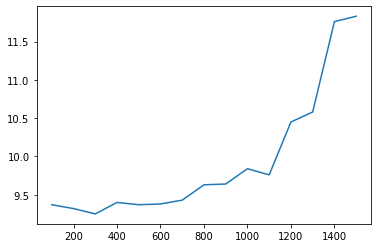

Curve n*18


<AxesSubplot:>

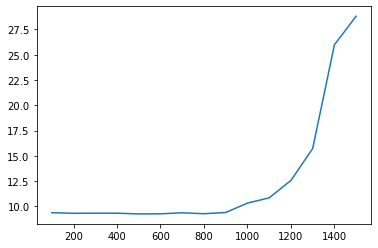

Curve n*19


<AxesSubplot:>

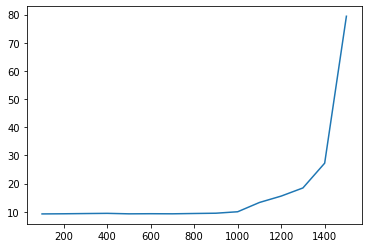

Curve n*81


<AxesSubplot:>

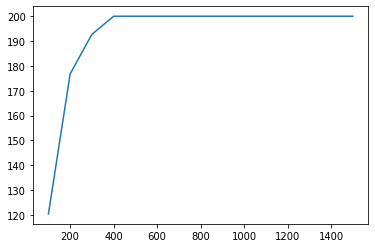

Curve n*115


<AxesSubplot:>

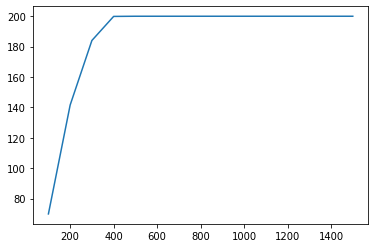

Curve n*118


<AxesSubplot:>

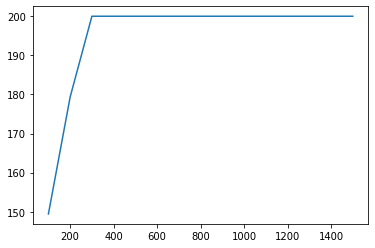

Curve n*123


<AxesSubplot:>

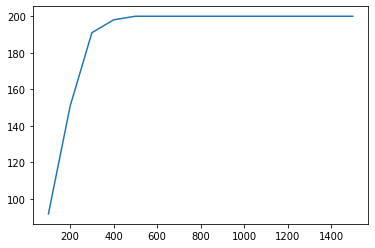

In [88]:
for i in range(len(x_)):
    print("Curve n*" + str(i_[i]))
    print_plot(x_, y_, i)

<AxesSubplot:>

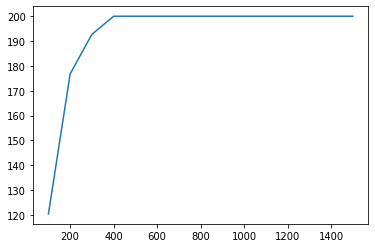

In [63]:

print_plot(x, y, two)